In [1]:
%matplotlib inline
from matplotlib.pyplot import *
from numpy import *
# Don't import too much globally like we did pyplot and numpy
# pandas will break datetime if they are imported globally.
import datetime
import pytz
import pysolar
import pandas              # pandas for data science

# This lets you make the default figure size larger (or smaller)
from IPython.core.pylabtools import figsize
figsize(10, 5)

## Solar Radiation from a Clear Sky
The functions from the Solar Values notebook are repeated here so this notebook can stand alone.

In [2]:
def solarR(d,elev = 0,dir = 180,latitude_deg = 44.2,longitude_deg = -76.5):
    # solar radiation falling on a surface at compass angle dir
    # and elevation angle elev under a clear sky at datetime d
    # in Kingston, Ontario
    rpd = pi / 180. # radians per degree
    azi = pysolar.solar.get_azimuth(latitude_deg, longitude_deg, d)   # azimuth angle
    alt = pysolar.solar.get_altitude(latitude_deg, longitude_deg, d)  # altitude angle
    # Unit vector pointing at the sun. RHR coords with x west, y south
    uVecSun = array([   sin((-180 + azi) * rpd) * cos(alt * rpd),
                        cos((-180 + azi) * rpd) * cos(alt * rpd),
                        sin(alt * rpd)])
    # Unit vector normal to the panel. RHR coords with x west, y south
    uVecPanel = array([ sin((-180 + dir) * rpd) * sin(elev * rpd),
                        cos((-180 + dir) * rpd) * sin(elev * rpd),
                        cos(elev * rpd)])
    # Reduce by the dot product between the sun vector and the panel vector
    rad = pysolar.solar.radiation.get_radiation_direct(d, alt) * dot(uVecSun,uVecPanel)
    if rad < 0: rad = 0   # sun is behind panel
    return rad

el = 90            # elevation of the panel, 0 degrees for horizontal
di = 180           # compass direction for the panel, 180 degrees for south

timezone = pytz.timezone("America/Toronto")  # includes Kingston


## Typical Meteoroligical Year (TMY)
In order to model building performance over time, you need extended historical data representing at least a full year. These Typical Meteorological Year (TMY) data sets can be enormous, with detailed information on temperature, humidity, sun, wind, etc. for a given location. We'll just look at a small excerpt. 

This data is for Toronto in the first 14 days of November 2013, providing outdoor temperature and solar radiation intensity on a south facing vertical surface like a window. It was provided by Prof. Steve Harrison of the Queen's Solar Calorimetry Lab housed in Mechanical and Materials Engineering. It seems reasonable to expect Toronto data to be similar to the situation in Kingston. To make sense of it, we should probably compare it to clear sky expectations for the same period of time. It's important to note that November is a gloomy month generally (averaging $2.41\rm\;kWh/m^2$ from the NRCan data) and this historical period looks especially gloomy.

How well would your design function in a period with this little sunlight?

The mean daily insolation is 1.552 kWh/m**2 for the Toronto TMY data.
The mean daily insolation is 4.848 kWh/m**2 for clear skies in Kingston.


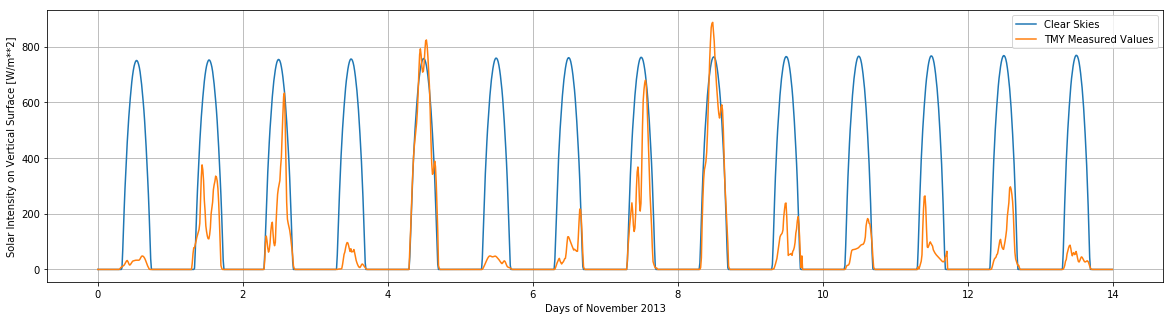

In [8]:
figsize(20, 5)

dfTMY = pandas.read_csv('Toronto TMY Nov13.csv')
x = dfTMY.as_matrix()
day = x[:,0].astype(int)
hour = (24*(x[:,0]-day)).astype(int)
minute = (60*24*(x[:,0]-day-hour/24)).astype(int)
i = zeros(len(day))              # intensity vectors for differnet dates
for j in range(0,len(day)): # for all the different hours in the day 
    # pysolar 0.8 requires timezone aware datetimes
    d = timezone.localize(datetime.datetime(2013, 11, day[j]+1, hour[j], minute[j]))  # November 2013
    i[j] = solarR(d,el,di)

plot(x[:,0],i, label="Clear Skies")
plot(x[:,0],x[:,2], label = "TMY Measured Values")
xlabel('Days of November 2013')
ylabel('Solar Intensity on Vertical Surface [W/m**2]')
grid()
legend()
# Average over the entire period and multiply by 24 hours per day.
# Divide by 1000 for kiloWatts
print('The mean daily insolation is {0:5.3f} kWh/m**2 for the Toronto TMY data.'.format(mean(x[:,2])*24/1000))
print('The mean daily insolation is {0:5.3f} kWh/m**2 for clear skies in Kingston.'.format(mean(i)*24/1000))



On sunny days the measured data is very close to the predicted clear sky values, which is reassuring. On gloomy days the total insolation can wind up at less than 10% of the clear sky values, as verfified in the calculations below.

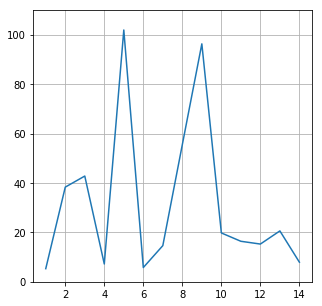

In [9]:
figsize(5, 5)

dailyClear = zeros(14)
dailyTMY = zeros(14)
daily = zeros(14)
for j in range(0,14):
    daily[j] = j + 1   # the day number 1 to 14
    # average over the 96 quarter hour readings for each day
    dailyClear[j] = mean(i[j*96:(j+1)*96])*24/1000
    dailyTMY[j] = mean(x[j*96:(j+1)*96,2])*24/1000    
plot(daily,dailyTMY/dailyClear*100)
ylim(0,110)
grid()
